# Theory of the method

We could do with a way to estimate the riskiness of an incident, without necessarily casting judgement on whether it is a hazard or not. Here I propose a probabilistic model. This also features a "temperance" parameter which can be freely varied, allowing us to set a threshold beyond which we won't make a judgement on whether an observation is hazardous or not, on the grounds that we don't have any training data nearby. This is a way of encoding our belief about how well we are covering the space of possible motions.

There are three parts to this. First, we rescale each feature so that -- for all training data, together -- they have zero mean and unit variance. This is our justification for using a symmetric kernel to fit our data: since it is rescaled, we have little reason to believe any one direction should be preferred. This is not ideal of course, since some features are skewed by their very nature, but it will do for a first attempt.

Second, we estimate a probability density on each of the classes. Without any particular reason to choose otherwise, we do a Gaussian kernel estimate -- any method would fit into this framework, and a Gaussian kernel density estimate is a fairly common choice. Many people would leave it here, since combined with an estimate of the base rates of each class this gives a classifier using the Bayes decision rule. We go one step further:

We estimate a probability density for unseen data, i.e. the data not in our training sample. This can be quite broad -- the key thing is that it assigns a higher likelihood to "new" points than our class estimates. "New" in this case means "far from the training data". My first guess is that a unit Gaussian will work well, but there is an argument to be made that something more heavy-tailed, such as a Cauchy distribution, would be more appropriate. Indeed, some people even choose a kernel which is not strictly speaking a distribution, such as a $1/(1+x)$ density (this does not integrate).

By combining these results, we can get three estimates from each test point: the probabilities of the candidate being a hazard, non-hazardous, or something we have not seen yet. The result is tunable (using the temperance parameter, and possibly by adjusting the base-rate estimates for hazards) and easy to interpret. Furthermore, the formulas for incorporating the tuning parameters are very simple, so that computation can be done in real time using pre-computed features.

# A demonstration

Before we try this on real data, let's make up a simple one-dimensional test case to demonstrate the theory. We will do a simple classification problem with overlapping test data.

## Our test model

For now, let's pretend that for some feature we can measure, typical and hazardous incidents follow the distributions in the following plot:

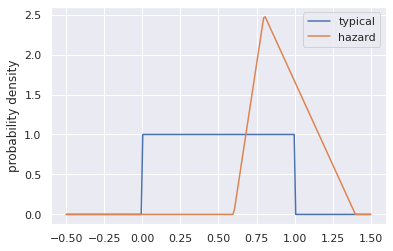

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sympy import lambdify, sqrt
from sympy.abc import t
from sympy.stats import Bernoulli, Normal, Uniform, Triangular, density, E, variance

typical = Uniform('T', 0, 1)
hazard = Triangular('H', 0.6, 1.4, 0.8)

x = np.linspace(-0.5, 1.5, 200)
typical_y = lambdify(t, density(typical)(t))(x)
hazard_y = lambdify(t, density(hazard)(t))(x)

plt.plot(x, typical_y, label="typical")
plt.plot(x, hazard_y, label="hazard")
plt.legend()
plt.ylabel('probability density')
plt.show()

The traditional method for deciding the thresholds is to look at where each distribution is greatest, scaling each one by its base rate. Assuming a base rate of 80% for typical events and 20% for hazards, that would look like this:

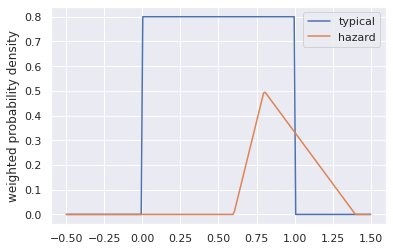

In [2]:
plt.plot(x, 0.8*typical_y, label="typical")
plt.plot(x, 0.2*hazard_y, label="hazard")
plt.legend()
plt.ylabel('weighted probability density')
plt.show()

Everywhere the hazard is higher, we would classify new incidents as hazards. Everywhere the typical behavior is higher, we would classify new incidents as typical.

## what makes our strategy different

Our strategy introduces an estimate of the distribution of unseen data. We do this by rescaling the data; this is equivalent to fitting a normal distribution to the data.

In [3]:
is_hazard = Bernoulli('z', 0.2)
observable = is_hazard * hazard + (1-is_hazard) * typical
mean = E(observable)
std = sqrt(variance(observable))

unseen = Normal('U', mean, std)
unseen_y = lambdify(t, density(unseen)(t))(x)

In [4]:
from ipywidgets import interact
import ipywidgets as widgets

In [5]:
@interact
def proprtional_plot(
    base_hazard_rate = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, readout_format='.2f'), 
    temperance = widgets.FloatSlider(value=0.3, min=0, max=1, step=0.01, readout_format='.2f')
):
    plt.plot(x, typical_y*(1-base_hazard_rate)*(1-temperance), label='typical')
    plt.plot(x, hazard_y*base_hazard_rate*(1-temperance), label='hazard')
    plt.plot(x, unseen_y * temperance, label='unseen')
    plt.legend()
    plt.ylabel('probability density')
    plt.show()

interactive(children=(FloatSlider(value=0.2, description='base_hazard_rate', max=1.0, step=0.01), FloatSlider(…

By modifying the temperance, we can specify the behavior at the tails: when the temperance is highest, we should conclude that we don't have a good idea of what the true class is.

# alternative unseen model

An alternative method would be to specify a cutoff probability denisty below which we refuse to estimate. Perhaps a good way to decide that would be to look at the probability density at each observed point, excluding the portion due to itself. This would provide a more believable behavior near the tails perhaps, but it would be harder to interpret from a Bayesian perspective.

# Attempt at application

The main way our method must necessarily differ from the toy model above is that we don't know the true densities of the distributions; we must estimate them. Let's do that now.

In [6]:
import git
import os
import sys
root = git.Repo(os.getcwd(), search_parent_directories=True).git.rev_parse("--show-toplevel")
sys.path.append(os.path.join(root, 'data_processing'))

from make_features import load_data, make_undirected

In [7]:
incidents, acceleration = load_data()
features = make_undirected(acceleration)

In [8]:
X = features.to_numpy()
y = (incidents['motion'] != 'other').to_numpy()

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


params = {"bandwidth": np.logspace(-1, 0, 50)}
grid = GridSearchCV(KernelDensity(), params)

grid.fit(X[y])
print("best bandwidth for hazards: {0}".format(grid.best_estimator_.bandwidth))
hazard_kde = grid.best_estimator_

grid = GridSearchCV(KernelDensity(), params)
grid.fit(X[~y])
print("best bandwidth for typicals: {0}".format(grid.best_estimator_.bandwidth))
typical_kde = grid.best_estimator_

best bandwidth for hazards: 0.5689866029018296
best bandwidth for typicals: 0.5689866029018296


We chose a bandwidth based on what number will give the highest likelihood of the observed sampling; this is a balance between covering nearby observations with a high probability density, and extending each point's reach.

# the likelihoods we see

Applying these density estimates, we can get an idea for the typical values of our estimators. Note that these give the log of the probability density, not the probability density directly. By 

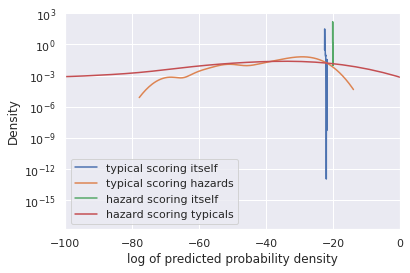

In [13]:
sns.kdeplot((typical_kde.score_samples(X[~y])), label="typical scoring itself")
sns.kdeplot((typical_kde.score_samples(X[y])), label="typical scoring hazards")
sns.kdeplot((hazard_kde.score_samples(X[y])), label="hazard scoring itself")
sns.kdeplot((hazard_kde.score_samples(X[~y])), label="hazard scoring typicals")
plt.legend()
plt.yscale('log')
plt.xlim(-100, 0)
plt.xlabel('log of predicted probability density')
plt.show()

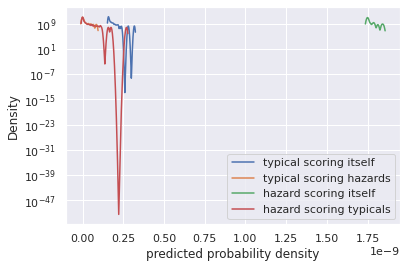

In [18]:
sns.kdeplot(np.exp(typical_kde.score_samples(X[~y])), label="typical scoring itself")
sns.kdeplot(np.exp(typical_kde.score_samples(X[y])), label="typical scoring hazards")
sns.kdeplot(np.exp(hazard_kde.score_samples(X[y])), label="hazard scoring itself")
sns.kdeplot(np.exp(hazard_kde.score_samples(X[~y])), label="hazard scoring typicals")
plt.legend()
plt.yscale('log')
plt.xlabel('predicted probability density')
plt.show()

We can use this to inform our choice of temperance. Since the typical values make up 90% of the data and have a predicted probaility of 10-30% for themselves, we should make sure our unseen data model does not predict a likelihood any greater than about 10%. If we choose a Gaussian, its peak value is at the center, $(2\pi)^{-d/2}$, where  the dimension $d$ is the number of features. In our case, that would be

In [17]:
peak_value = (2*np.pi)**(-X.shape[1]/2)
display(peak_value)
display(np.log(peak_value))

1.730703868730983e-17

-38.59541839459625

which is in the middle of the pack, relative to the probabilities that the typical-value distribution assigns to the hazards. This indicates that a temperance near 0.5 is fine, and we coudl possibly tolerate a higher temeperance without causing issues. Let's make that model now.

# the classifier

We will apply the strategy above to 